### データフォーマット

* 地域ごとのデータ・・・地域固有のID
* 年代・・・1992~2013年まで
* 土地の平均価格・・・1992~2013年まで
* 夜間光量の平均値・・・0~63までのレンジでその地域の平均光量
* 夜間光量の合計値・・・その地域の合計光量

データ数

・学習用データの数が世界1,118地域 (データ数: 21,883)
※学習用データには時系列が完全でないデータも存在しています。学習に使用する、使用しないは自由ですがご留意ください。

・評価用データの数が世界630地域 (データ数: 13,860)

# Data Exploration

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def from_ds_source():
    train = pd.read_csv('../input/solafunepredictlandprices/TrainDataSet.csv')
    test = pd.read_csv('../input/solafunepredictlandprices/EvaluationData.csv')
    dataset = pd.concat([train, test], axis=0)
    dataset['Area'] = dataset['SumLight'] / dataset['MeanLight']
    area_median = dataset.groupby('PlaceID')['Area'].median()
    dataset['Area'] = dataset['PlaceID'].map(area_median)
    return dataset

dataset = from_ds_source()

            PlaceID          Year  AverageLandPrice     MeanLight  \
count  35743.000000  35743.000000      21883.000000  35743.000000   
mean      -0.000849      0.503754          5.874543      0.388747   
std        0.576474      0.301215          1.124393      0.327089   
min       -0.998797      0.000000          2.389596      0.000000   
25%       -0.501805      0.238095          5.146675      0.112712   
50%        0.000000      0.523810          5.834279      0.261406   
75%        0.498195      0.761905          6.570456      0.649283   
max        1.000000      1.000000         11.628298      1.000000   

           SumLight          Area  
count  35743.000000  35722.000000  
mean       0.428858      0.401762  
std        1.379424      1.057534  
min       -0.699683     -0.510823  
25%       -0.344691     -0.316017  
50%        0.000000      0.000000  
75%        0.655309      0.683983  
max       15.620444      8.891775  


<AxesSubplot:>

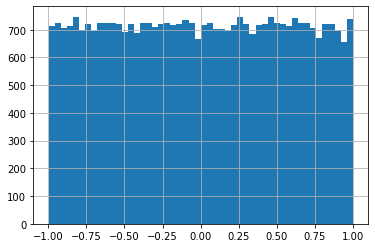

In [19]:
describe = dataset.describe()
print(describe)
dataset['PlaceID'].hist(bins=50)

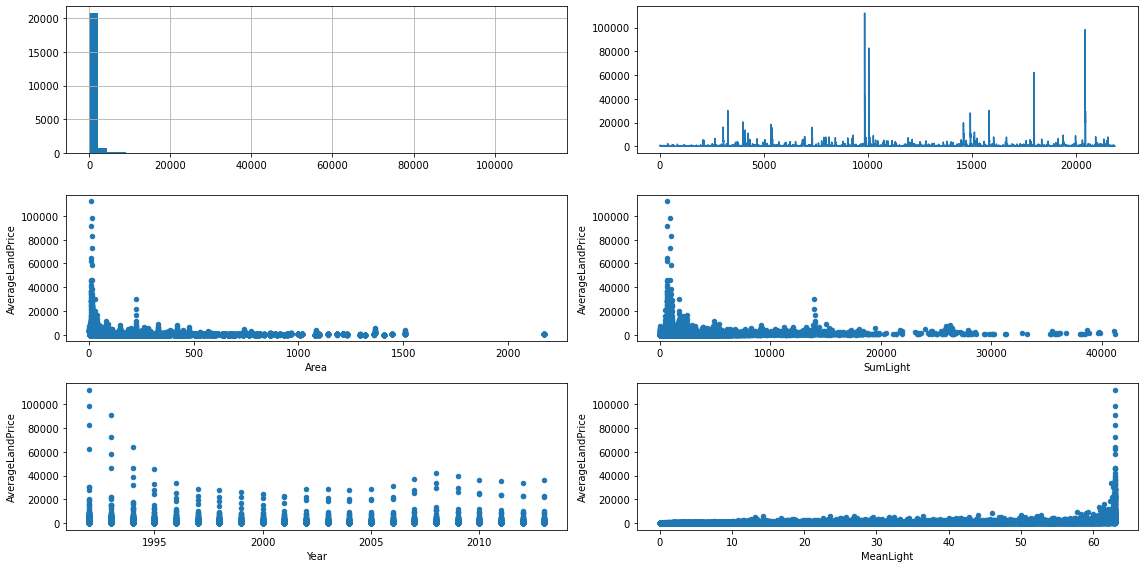

In [22]:
def draw_graph(dataset, left=0, right=0):
    fig, axes = plt.subplots(3,2, figsize=(16,8))
    dataset['AverageLandPrice'].hist(ax=axes[0,0], bins=50)
    if left !=0:
        axes[0,0].axvline(left, color='b', linestyle='--')
        axes[0,0].axvline(right, color='r', linestyle='--')
        
    dataset['AverageLandPrice'].plot(ax=axes[0,1])
    if 'Area' in dataset.columns:
        dataset.plot.scatter(x='Area', y='AverageLandPrice', ax=axes[1,0])
    dataset.plot.scatter(x='SumLight', y='AverageLandPrice', ax=axes[1,1])
    dataset.plot.scatter(x='Year', y='AverageLandPrice', ax=axes[2,0])
    dataset.plot.scatter(x='MeanLight', y='AverageLandPrice', ax=axes[2,1])
    plt.tight_layout()

dataset = from_ds_source()
draw_graph(dataset)

train data size: (21883, 6)
test data size: (13860, 5)
final train data size: (21860, 6)


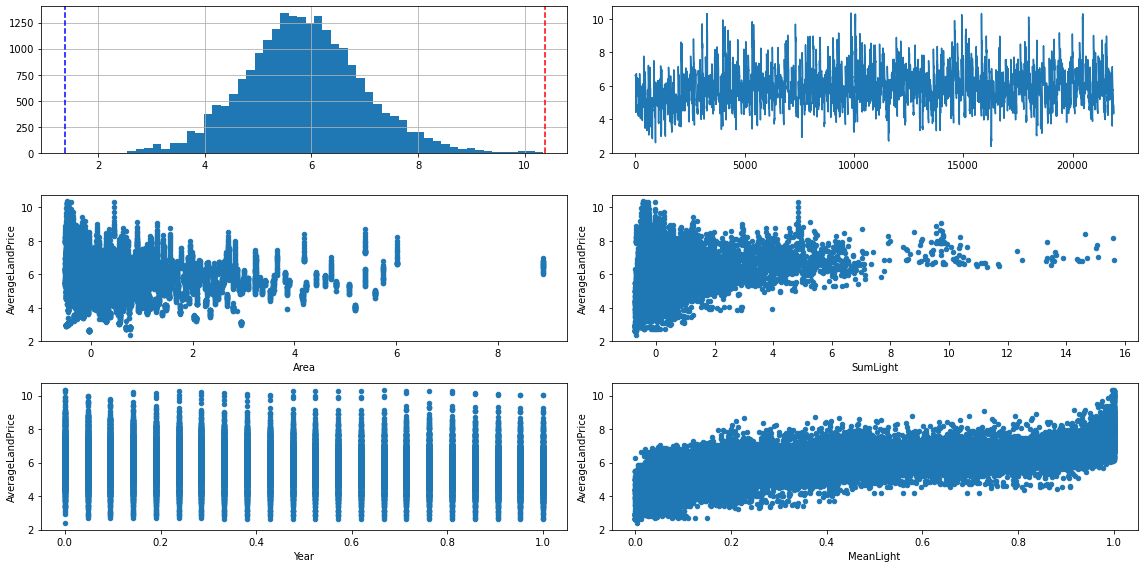

In [29]:
dataset = from_ds_source()
PlaceID = dataset.loc[dataset['AverageLandPrice'].isnull(), 'PlaceID']
Year = dataset.loc[dataset['AverageLandPrice'].isnull(), 'Year']
answer = dataset.loc[dataset['AverageLandPrice'].notnull(), 'AverageLandPrice']

#draw_graph(dataset)
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# Normalize 'AverageLandPrice'
dataset['AverageLandPrice'] = np.log(dataset['AverageLandPrice'])

train = dataset.loc[dataset['AverageLandPrice'].notnull(), :]
print(f'train data size: {train.shape}')
test = dataset.loc[dataset['AverageLandPrice'].isnull(), :].drop(['AverageLandPrice'], axis=1)
print(f'test data size: {test.shape}')

describe = train.describe()
price_l = describe.loc['mean', 'AverageLandPrice'] - (describe.loc['std', 'AverageLandPrice'] * 4)
price_r = describe.loc['mean', 'AverageLandPrice'] + (describe.loc['std', 'AverageLandPrice'] * 4)

train = train[(train['AverageLandPrice'] < price_r) & (train['AverageLandPrice'] > price_l)]
draw_graph(train, price_l, price_r)
print(f'final train data size: {train.shape}')

In [31]:
minmax = MinMaxScaler()
robscr = RobustScaler()
stdscr = StandardScaler()

X = train.loc[:, train.drop(columns='AverageLandPrice', axis=1).columns]
y = train['AverageLandPrice']

X = robscr.fit_transform(X)
test = robscr.fit_transform(test)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

print(X)
print(y)

[[ 0.38452237 -0.90909091  1.22186392 -0.52038442 -0.5046729 ]
 [ 0.38452237 -0.81818182  1.3733952  -0.50581689 -0.5046729 ]
 [ 0.38452237 -0.72727273  1.34813995 -0.50824482 -0.5046729 ]
 ...
 [ 0.40024184  0.72727273 -0.10331839 -0.20435003 -0.12149533]
 [ 0.40024184  0.81818182 -0.06856405 -0.18735458 -0.12149533]
 [ 0.40024184  0.90909091 -0.09107619 -0.21487102 -0.12149533]]
0        6.607878
1        6.605827
2        6.605827
3        6.605827
4        6.605827
           ...   
21878    4.603350
21879    4.543295
21880    4.492714
21881    4.442651
21882    4.388822
Name: AverageLandPrice, Length: 21860, dtype: float64


In [33]:
import optuna.integration.lightgbm as lgb

params = {
    'objective': 'mean_squared_error',
    'metric': 'rmse'
}

# Data Preprocessing

trains = lgb.Dataset(X_tr, y_tr)
tests = lgb.Dataset(X_te, y_te)

model = lgb.train(params, trains, valid_sets=tests, verbose_eval=False)
print(f'best params = {model.params}')
print(f'best score = {model.best_score}')
best_params = model.params

[I 2021-02-19 08:16:23,728] A new study created in memory with name: no-name-8fc9d684-02f0-4f12-9eb9-84a311e7cdea
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


feature_fraction, val_score: 0.210442:  14%|#4        | 1/7 [00:01<00:08,  1.41s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


feature_fraction, val_score: 0.210442:  29%|##8       | 2/7 [00:02<00:06,  1.34s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


feature_fraction, val_score: 0.210442:  43%|####2     | 3/7 [00:03<00:04,  1.23s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


feature_fraction, val_score: 0.208403:  57%|#####7    | 4/7 [00:04<00:03,  1.20s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


feature_fraction, val_score: 0.208403:  71%|#######1  | 5/7 [00:06<00:02,  1.47s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


feature_fraction, val_score: 0.205613:  86%|########5 | 6/7 [00:08<00:01,  1.41s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.205613:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.183971:   5%|5         | 1/20 [00:03<01:00,  3.17s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.183971:  10%|#         | 2/20 [00:09<01:28,  4.92s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.183971:  15%|#5        | 3/20 [00:15<01:31,  5.37s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.183971:  20%|##        | 4/20 [00:15<00:54,  3.43s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.183250:  25%|##5       | 5/20 [00:19<00:52,  3.47s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.183250:  30%|###       | 6/20 [00:23<00:51,  3.65s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.182687:  35%|###5      | 7/20 [00:27<00:49,  3.79s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.182687:  40%|####      | 8/20 [00:33<00:54,  4.57s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.182687:  45%|####5     | 9/20 [00:35<00:41,  3.74s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.182687:  50%|#####     | 10/20 [00:41<00:43,  4.37s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.182687:  55%|#####5    | 11/20 [00:48<00:46,  5.13s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.182687:  60%|######    | 12/20 [00:51<00:37,  4.70s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.182687:  65%|######5   | 13/20 [00:54<00:28,  4.06s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.182687:  70%|#######   | 14/20 [00:58<00:25,  4.18s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.182687:  75%|#######5  | 15/20 [01:01<00:18,  3.69s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.182033:  80%|########  | 16/20 [01:04<00:14,  3.56s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.182033:  85%|########5 | 17/20 [01:06<00:09,  3.18s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.182033:  90%|######### | 18/20 [01:07<00:04,  2.38s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


num_leaves, val_score: 0.182033:  95%|#########5| 19/20 [01:09<00:02,  2.22s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


bagging, val_score: 0.182033:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


bagging, val_score: 0.182033:  10%|#         | 1/10 [00:04<00:36,  4.09s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


bagging, val_score: 0.182033:  20%|##        | 2/10 [00:08<00:32,  4.00s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


bagging, val_score: 0.182033:  30%|###       | 3/10 [00:12<00:27,  3.99s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


bagging, val_score: 0.177698:  40%|####      | 4/10 [00:15<00:22,  3.74s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


bagging, val_score: 0.177698:  50%|#####     | 5/10 [00:19<00:18,  3.74s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


bagging, val_score: 0.177698:  60%|######    | 6/10 [00:23<00:16,  4.10s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


bagging, val_score: 0.177698:  70%|#######   | 7/10 [00:27<00:12,  4.02s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


bagging, val_score: 0.177698:  80%|########  | 8/10 [00:31<00:07,  3.92s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


bagging, val_score: 0.177698:  90%|######### | 9/10 [00:35<00:03,  3.90s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


feature_fraction_stage2, val_score: 0.177698:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


feature_fraction_stage2, val_score: 0.177698:  33%|###3      | 1/3 [00:03<00:07,  3.66s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


feature_fraction_stage2, val_score: 0.177698:  67%|######6   | 2/3 [00:07<00:03,  3.65s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.177698:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.177661:   5%|5         | 1/20 [00:04<01:26,  4.58s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.177661:  10%|#         | 2/20 [00:08<01:12,  4.01s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.177661:  15%|#5        | 3/20 [00:11<01:05,  3.85s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.176761:  20%|##        | 4/20 [00:15<01:01,  3.81s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.176761:  25%|##5       | 5/20 [00:19<00:55,  3.70s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.176761:  30%|###       | 6/20 [00:23<00:52,  3.77s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.176761:  35%|###5      | 7/20 [00:26<00:48,  3.76s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


regularization_factors, val_score: 0.176761:  40%|####      | 8/20 [00:30<00:46,  3.84s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.176761:  45%|####5     | 9/20 [00:35<00:44,  4.09s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.176761:  50%|#####     | 10/20 [00:39<00:39,  3.98s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.176761:  55%|#####5    | 11/20 [00:42<00:34,  3.86s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.176761:  60%|######    | 12/20 [00:46<00:30,  3.78s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.176761:  65%|######5   | 13/20 [00:50<00:26,  3.75s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.176761:  70%|#######   | 14/20 [00:53<00:22,  3.75s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.176761:  75%|#######5  | 15/20 [00:57<00:18,  3.72s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.176761:  80%|########  | 16/20 [01:01<00:14,  3.72s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.176761:  85%|########5 | 17/20 [01:05<00:11,  3.97s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.176761:  90%|######### | 18/20 [01:09<00:07,  3.89s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


regularization_factors, val_score: 0.176761:  95%|#########5| 19/20 [01:12<00:03,  3.76s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


min_data_in_leaf, val_score: 0.176761:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


min_data_in_leaf, val_score: 0.176761:  20%|##        | 1/5 [00:03<00:15,  3.89s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


min_data_in_leaf, val_score: 0.176761:  40%|####      | 2/5 [00:07<00:11,  3.78s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


min_data_in_leaf, val_score: 0.175609:  60%|######    | 3/5 [00:11<00:07,  3.83s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


min_data_in_leaf, val_score: 0.175249:  80%|########  | 4/5 [00:15<00:03,  3.87s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 17488, number of used features: 5
[LightGBM] [Info] Start training from score 5.863419


min_data_in_leaf, val_score: 0.175249: 100%|##########| 5/5 [00:19<00:00,  3.89s/it]

best params = {'objective': 'mean_squared_error', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 2.136430177615463e-08, 'lambda_l2': 3.3053363180471442, 'num_leaves': 98, 'feature_fraction': 1.0, 'bagging_fraction': 0.829078474636199, 'bagging_freq': 1, 'min_child_samples': 10, 'num_iterations': 1000, 'early_stopping_round': None}
best score = defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('rmse', 0.17524888535917457)])})


best params = {'objective': 'mean_squared_error', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 3.645456487763708e-07, 'lambda_l2': 5.922038673037026, 'num_leaves': 126, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.8620944703222093, 'bagging_freq': 7, 'min_child_samples': 10, 'num_iterations': 1000, 'early_stopping_round': None}
best score = defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('rmse', 0.17482201501063688)])})


In [41]:
import lightgbm as lgb

regressor = lgb.LGBMRegressor(**best_params)
regressor.fit(X_tr, y_tr, eval_set=(X_te, y_te), verbose=0)
y_pred = np.exp(regressor.predict(X_te))

from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(np.exp(y_te), y_pred)))

draw_pred_graph(np.exp(y_te), y_pred)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] lambda_l1 is set=2.136430177615463e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.136430177615463e-08
[LightGBM] [Warning] bagging_fraction is set=0.829078474636199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.829078474636199
[LightGBM] [Warning] lambda_l2 is set=3.3053363180471442, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3053363180471442
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
397.0435130325654


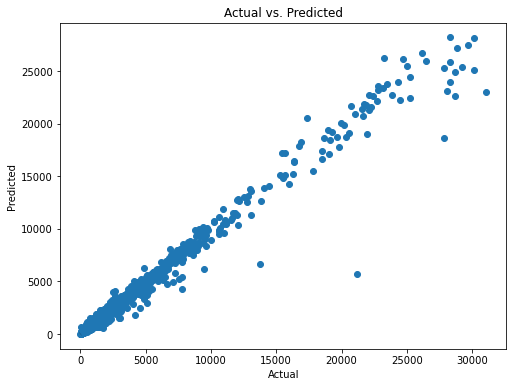

In [38]:
def draw_pred_graph(y_act, y_pred):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(y_act, y_pred)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title('Actual vs. Predicted')
    plt.show()

y_act = np.exp(y)
y_pred = np.exp(regressor.predict(X))
draw_pred_graph(y_act, y_pred)

In [39]:
y_pred = np.exp(regressor.predict(test))

result = pd.DataFrame({'PlaceID': PlaceID, 'Year': Year, 'LandPrice': y_pred})
result.to_csv('submission.csv', index=False)

result

,PlaceID,Year,LandPrice
0,1387,1992,1277.188151
1,1387,1993,1955.101074
2,1387,1994,1093.290076
3,1387,1995,1524.150702
4,1387,1996,1524.150702
...,...,...,...
13855,693,2009,167.677292
13856,693,2010,159.058712
13857,693,2011,159.348921
13858,693,2012,128.683012
